# CTS

Import thư viện cần thiết

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [138]:
# 2. Đọc file csv và gắng index với giá Close
df1= pd.read_csv('DataCTS.csv')
df_CTS=df1.reset_index()['Price']

In [140]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_CTS=scaler.fit_transform(np.array(df_CTS).reshape(-1,1))

In [141]:
df_CTS

array([[0.06680277],
       [0.0638417 ],
       [0.06022094],
       ...,
       [0.99125422],
       [0.96626628],
       [0.96626628]])

In [144]:
# 4. Chia train test
train_size = int(len(df_CTS) * 0.8)
test_size = len(df_CTS) - train_size
train_data, test_data = df_CTS[0:train_size, :], df_CTS[train_size:len(df_CTS), :1]


In [145]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [146]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [147]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [148]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [117]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 11s 162ms/step - loss: 0.0205
Epoch 2/100
24/24 [==============================] - 4s 165ms/step - loss: 0.0029
Epoch 3/100
24/24 [==============================] - 6s 241ms/step - loss: 0.0018
Epoch 4/100
24/24 [==============================] - 4s 165ms/step - loss: 0.0016
Epoch 5/100
24/24 [==============================] - 4s 169ms/step - loss: 0.0014
Epoch 6/100
24/24 [==============================] - 6s 244ms/step - loss: 0.0013
Epoch 7/100
24/24 [==============================] - 4s 166ms/step - loss: 0.0012
Epoch 8/100
24/24 [==============================] - 4s 164ms/step - loss: 0.0010
Epoch 9/100
24/24 [==============================] - 6s 241ms/step - loss: 9.3625e-04
Epoch 10/100
24/24 [==============================] - 4s 171ms/step - loss: 8.1464e-04
Epoch 11/100
24/24 [==============================] - 8s 328ms/step - loss: 7.4455e-04
Epoch 12/100
24/24 [==============================] - 8s 336ms/step - loss: 6.9852e

In [118]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 1s 53ms/step


In [119]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

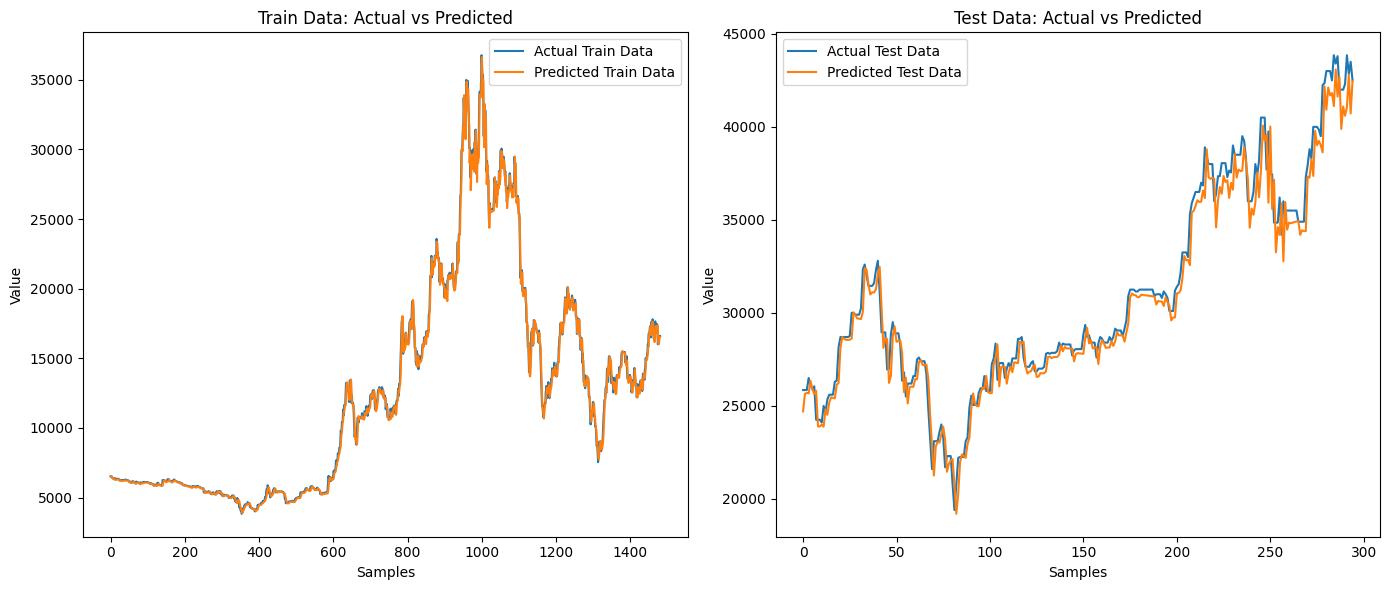

In [120]:
# Vẽ giá trị dự đoán và giá trị thực tế cho tập kiểm tra
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual Train Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual Test Data')
plt.plot(y_pred, label='Predicted Test Data')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [121]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))
print('Testing RMSE:', test_rmse)

mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f'Testing MAPE: {mape}')

mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Testing MAE: {mae}')

Testing RMSE: 1024.2162624000832
Testing MAPE: 0.02320296108896799
Testing MAE: 734.3085738877119


In [122]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30_days=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30_days.extend(yhat.tolist())
        i=i+1

0 day input [0.44776645 0.471505   0.46026042 0.45276404 0.46275922 0.46275922
 0.46275922 0.4702556  0.46650741 0.47775198 0.47900138 0.48150018
 0.48150018 0.48150018 0.47900138 0.471505   0.4690062  0.4690062
 0.50773752 0.50773752 0.50773752 0.52772787 0.51898209 0.52897727
 0.52647847 0.53397486 0.53397486 0.53397486 0.54896762 0.53897245
 0.55396521 0.55271581 0.56271099 0.56271099 0.56271099 0.57395557
 0.5602122  0.54771823 0.52897727 0.55021702 0.55021702 0.55021702
 0.56645918 0.55646401 0.55146642 0.55521461 0.51023631 0.51023631
 0.51023631 0.50648812 0.52897727 0.52023149 0.53772305 0.54397003
 0.54397003 0.54397003 0.56146159 0.56271099 0.60768929 0.62143266
 0.62143266 0.62143266 0.62143266 0.62143266 0.62268206 0.65391699
 0.65391699 0.65141819 0.65141819 0.65141819 0.66016397 0.71263865
 0.71888564 0.70389287 0.6901495  0.6901495  0.6901495  0.69389769
 0.71138925 0.72388323 0.68140372 0.62767964 0.62767964 0.62767964
 0.57770376 0.57895316 0.62518085 0.64142301 0.6264

In [126]:
#14. Dự đoán 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60_days=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60_days.extend(yhat.tolist())
        i=i+1

0 day input [0.44776645 0.471505   0.46026042 0.45276404 0.46275922 0.46275922
 0.46275922 0.4702556  0.46650741 0.47775198 0.47900138 0.48150018
 0.48150018 0.48150018 0.47900138 0.471505   0.4690062  0.4690062
 0.50773752 0.50773752 0.50773752 0.52772787 0.51898209 0.52897727
 0.52647847 0.53397486 0.53397486 0.53397486 0.54896762 0.53897245
 0.55396521 0.55271581 0.56271099 0.56271099 0.56271099 0.57395557
 0.5602122  0.54771823 0.52897727 0.55021702 0.55021702 0.55021702
 0.56645918 0.55646401 0.55146642 0.55521461 0.51023631 0.51023631
 0.51023631 0.50648812 0.52897727 0.52023149 0.53772305 0.54397003
 0.54397003 0.54397003 0.56146159 0.56271099 0.60768929 0.62143266
 0.62143266 0.62143266 0.62143266 0.62143266 0.62268206 0.65391699
 0.65391699 0.65141819 0.65141819 0.65141819 0.66016397 0.71263865
 0.71888564 0.70389287 0.6901495  0.6901495  0.6901495  0.69389769
 0.71138925 0.72388323 0.68140372 0.62767964 0.62767964 0.62767964
 0.57770376 0.57895316 0.62518085 0.64142301 0.6264

In [128]:
#14. Dự đoán 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90_days=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.56895798 0.56895798 0.59144713 0.59394592 0.58894833 0.58894833
 0.58894833 0.57145677 0.52522908 0.48399897 0.44401826 0.48150018
 0.48150018 0.48150018 0.49399415 0.50398933 0.48649776 0.44651706
 0.46150982 0.46150982 0.46150982 0.42402791 0.38904479 0.42277851
 0.45901103 0.46026042 0.46026042 0.46026042 0.48150018 0.48649776
 0.52647847 0.54272064 0.53022667 0.53022667 0.53022667 0.54646883
 0.55271581 0.55146642 0.56895798 0.54896762 0.54896762 0.54896762
 0.58520014 0.59269652 0.61268688 0.56396039 0.58644954 0.58644954
 0.58644954 0.56645918 0.57895316 0.58644954 0.58020255 0.59269652
 0.59269652 0.59269652 0.61893386 0.61893386 0.62143266 0.59394592
 0.58145195 0.58145195 0.58145195 0.58644954 0.58894833 0.57520496
 0.57520496 0.57895316 0.57895316 0.57895316 0.58145195 0.59894351
 0.60019291 0.59894351 0.60019291 0.60019291 0.60019291 0.6026917
 0.61393628 0.60768929 0.61268688 0.61143748 0.61143748 0.61143748
 0.611

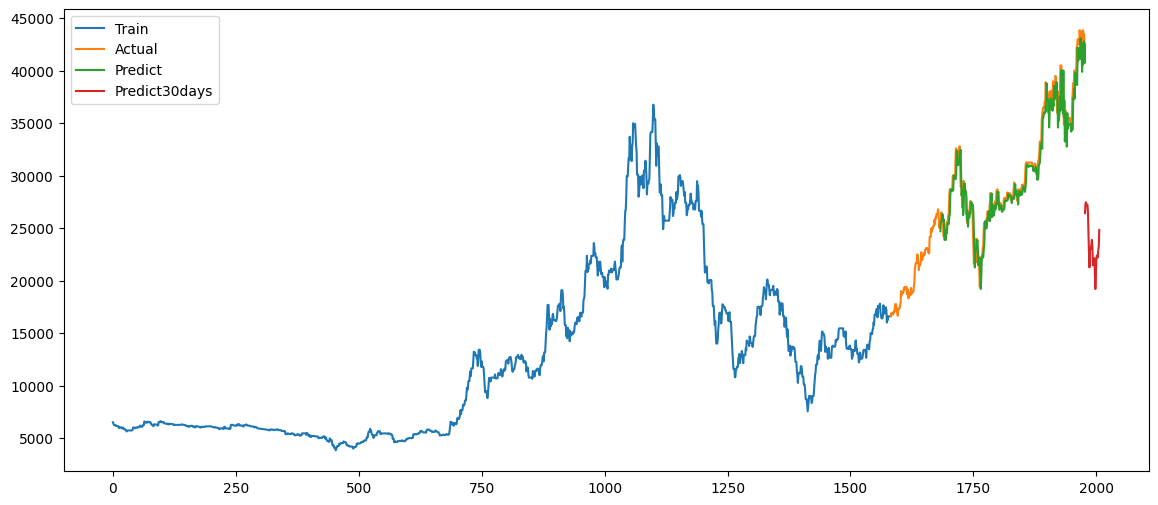

In [129]:
# 14.Vẽ hình 30 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_30_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30_days, scaler.inverse_transform(lst_output_30_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()


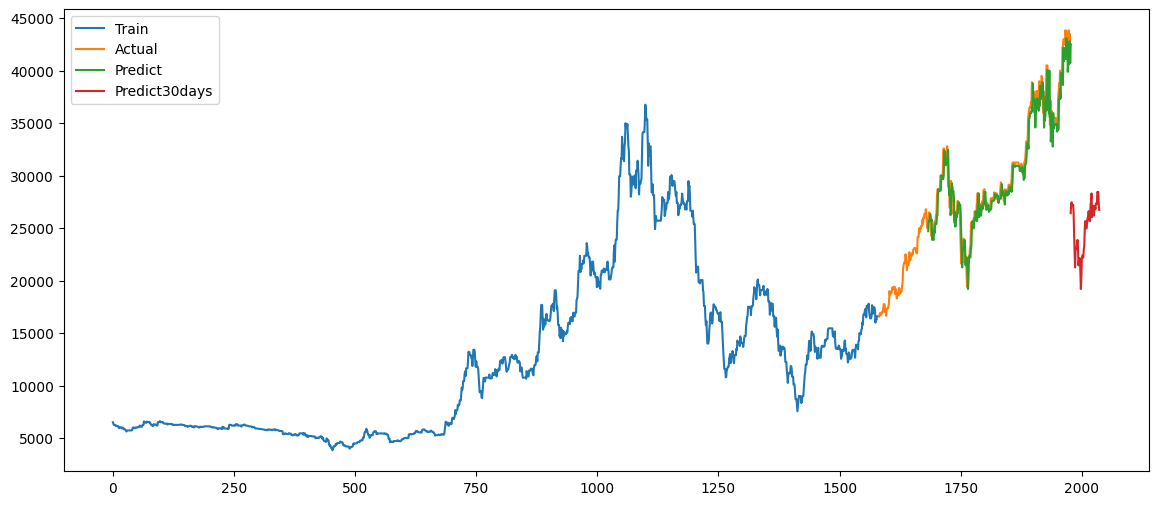

In [130]:
# 14.Vẽ hình 60 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_60_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60_days, scaler.inverse_transform(lst_output_60_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()

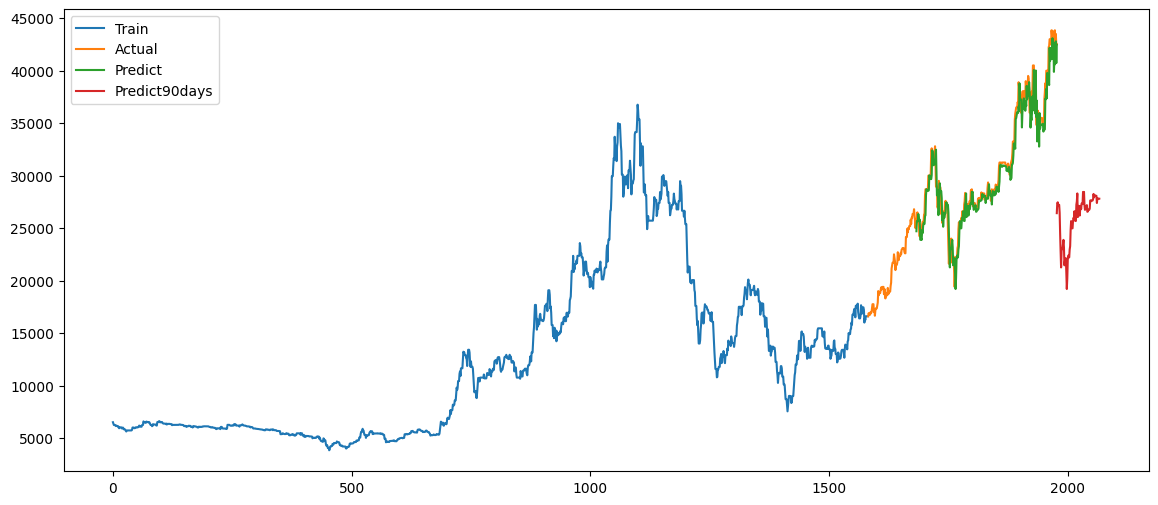

In [131]:
# 14.Vẽ hình 90 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_90_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90_days, scaler.inverse_transform(lst_output_90_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict90days'])
plt.show()

# ACB

In [158]:
# 2. Đọc file csv và gắng index với giá Close
df2= pd.read_csv('DataACB.csv')
df_ACB=df2.reset_index()['Price']

In [159]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_ACB=scaler.fit_transform(np.array(df_ACB).reshape(-1,1))

In [160]:
df_ACB

array([[0.10626062],
       [0.08697082],
       [0.09048058],
       ...,
       [0.77797739],
       [0.7356102 ],
       [0.7356102 ]])

In [161]:
# 4. Chia train test
train_size = int(len(df_ACB) * 0.8)
test_size = len(df_ACB) - train_size
train_data, test_data = df_ACB[0:train_size, :], df_ACB[train_size:len(df_ACB), :1]


In [162]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [163]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [164]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [165]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [166]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 12s 237ms/step - loss: 0.0537
Epoch 2/100
24/24 [==============================] - 4s 169ms/step - loss: 0.0041
Epoch 3/100
24/24 [==============================] - 4s 171ms/step - loss: 0.0021
Epoch 4/100
24/24 [==============================] - 6s 233ms/step - loss: 0.0018
Epoch 5/100
24/24 [==============================] - 4s 169ms/step - loss: 0.0018
Epoch 6/100
24/24 [==============================] - 4s 169ms/step - loss: 0.0018
Epoch 7/100
24/24 [==============================] - 6s 235ms/step - loss: 0.0017
Epoch 8/100
24/24 [==============================] - 4s 168ms/step - loss: 0.0017
Epoch 9/100
24/24 [==============================] - 4s 170ms/step - loss: 0.0017
Epoch 10/100
24/24 [==============================] - 6s 248ms/step - loss: 0.0016
Epoch 11/100
24/24 [==============================] - 5s 200ms/step - loss: 0.0016
Epoch 12/100
24/24 [==============================] - 4s 168ms/step - loss: 0.0016
Epoch 13/100

In [167]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 39ms/step


In [168]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

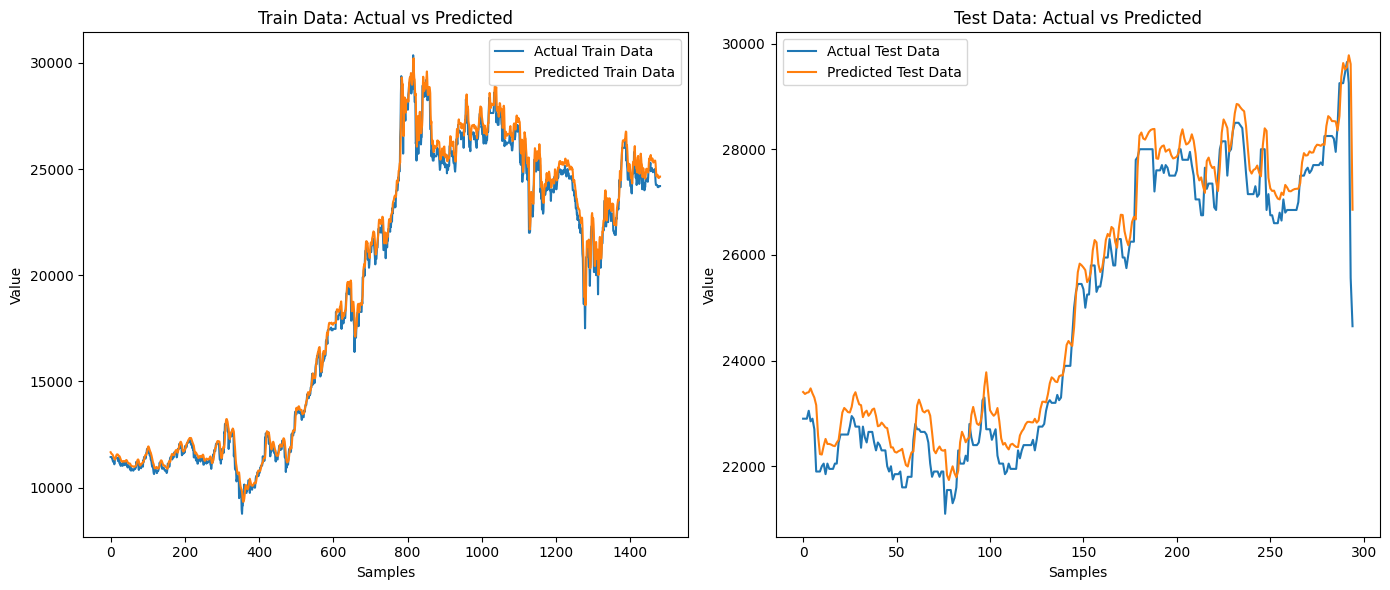

In [169]:
# Vẽ giá trị dự đoán và giá trị thực tế cho tập kiểm tra
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual Train Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual Test Data')
plt.plot(y_pred, label='Predicted Test Data')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [170]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))
print('Testing RMSE:', test_rmse)

mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f'Testing MAPE: {mape}')

mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Testing MAE: {mae}')

Testing RMSE: 535.9316628356212
Testing MAPE: 0.01767454841643647
Testing MAE: 431.3406779661018


In [171]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30_days=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30_days.extend(yhat.tolist())
        i=i+1

0 day input [0.61522256 0.61290741 0.61059226 0.59901653 0.59901653 0.59901653
 0.59901653 0.61059226 0.61290741 0.60596197 0.61290741 0.61290741
 0.61290741 0.61290741 0.61290741 0.61290741 0.61290741 0.61290741
 0.6175377  0.6175377  0.6175377  0.61522256 0.62679829 0.62679829
 0.61985285 0.622168   0.622168   0.622168   0.6568952  0.65226491
 0.66384064 0.68004667 0.72403447 0.72403447 0.72403447 0.69393756
 0.67773153 0.66847094 0.65458006 0.65458006 0.65458006 0.65458006
 0.6615255  0.65226491 0.65458006 0.64531947 0.60827711 0.60827711
 0.60827711 0.61290741 0.61522256 0.60596197 0.61522256 0.61059226
 0.61059226 0.61059226 0.61522256 0.61522256 0.63374373 0.64068917
 0.64068917 0.64068917 0.64068917 0.64068917 0.64763461 0.6568952
 0.65458006 0.64763461 0.64763461 0.64763461 0.62911344 0.64763461
 0.63837403 0.63374373 0.64300432 0.64300432 0.64300432 0.63374373
 0.62679829 0.63374373 0.63142858 0.62679829 0.62679829 0.62679829
 0.61290741 0.60827711 0.61290741 0.60133167 0.6059

In [172]:
#14. Dự đoán 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60_days=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60_days.extend(yhat.tolist())
        i=i+1

0 day input [0.61522256 0.61290741 0.61059226 0.59901653 0.59901653 0.59901653
 0.59901653 0.61059226 0.61290741 0.60596197 0.61290741 0.61290741
 0.61290741 0.61290741 0.61290741 0.61290741 0.61290741 0.61290741
 0.6175377  0.6175377  0.6175377  0.61522256 0.62679829 0.62679829
 0.61985285 0.622168   0.622168   0.622168   0.6568952  0.65226491
 0.66384064 0.68004667 0.72403447 0.72403447 0.72403447 0.69393756
 0.67773153 0.66847094 0.65458006 0.65458006 0.65458006 0.65458006
 0.6615255  0.65226491 0.65458006 0.64531947 0.60827711 0.60827711
 0.60827711 0.61290741 0.61522256 0.60596197 0.61522256 0.61059226
 0.61059226 0.61059226 0.61522256 0.61522256 0.63374373 0.64068917
 0.64068917 0.64068917 0.64068917 0.64068917 0.64763461 0.6568952
 0.65458006 0.64763461 0.64763461 0.64763461 0.62911344 0.64763461
 0.63837403 0.63374373 0.64300432 0.64300432 0.64300432 0.63374373
 0.62679829 0.63374373 0.63142858 0.62679829 0.62679829 0.62679829
 0.61290741 0.60827711 0.61290741 0.60133167 0.6059

In [173]:
#14. Dự đoán 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90_days=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.63605888 0.64994976 0.64531947 0.64531947 0.64300432 0.64300432
 0.64300432 0.64068917 0.63374373 0.61522256 0.60364682 0.60827711
 0.60827711 0.60827711 0.60364682 0.60827711 0.60827711 0.57123476
 0.59207108 0.59207108 0.59207108 0.58049535 0.58512564 0.59438623
 0.62679829 0.61522256 0.61522256 0.61522256 0.622168   0.6175377
 0.64994976 0.63837403 0.63142858 0.63142858 0.63142858 0.63374373
 0.64531947 0.67078609 0.67310123 0.64531947 0.64531947 0.64531947
 0.63605888 0.64068917 0.64531947 0.622168   0.61522256 0.61522256
 0.61522256 0.60596197 0.60827711 0.61522256 0.61059226 0.61059226
 0.61059226 0.61059226 0.62679829 0.61985285 0.62679829 0.63142858
 0.63142858 0.63142858 0.63142858 0.63142858 0.63605888 0.62679829
 0.63605888 0.64763461 0.64763461 0.64763461 0.64994976 0.6615255
 0.66847094 0.67078609 0.66847094 0.66847094 0.66847094 0.67541638
 0.67078609 0.67310123 0.69393756 0.700883   0.700883   0.700883
 0.700883

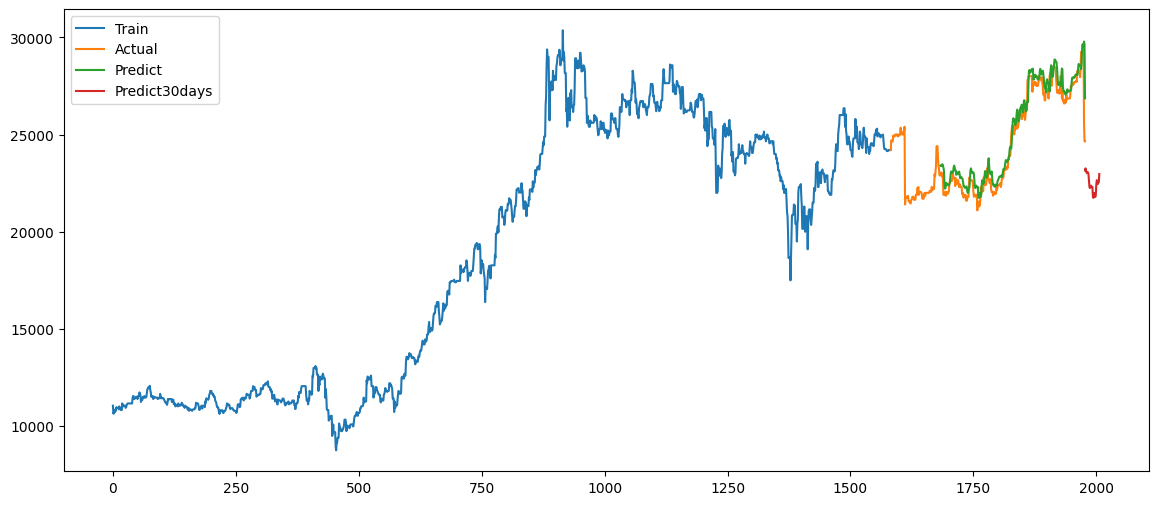

In [174]:
# 14.Vẽ hình 30 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_30_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30_days, scaler.inverse_transform(lst_output_30_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()


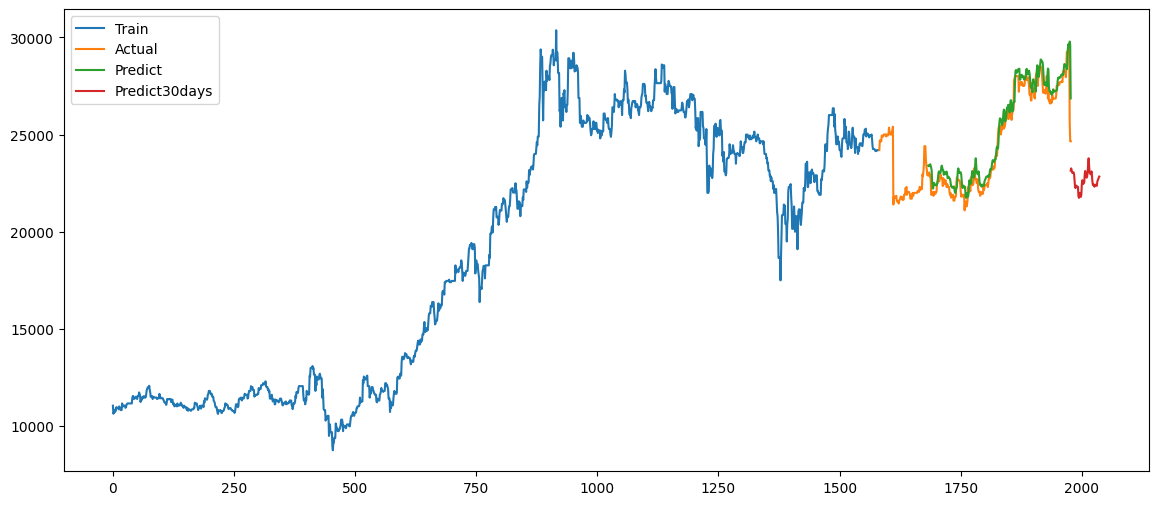

In [175]:
# 14.Vẽ hình 60 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_60_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60_days, scaler.inverse_transform(lst_output_60_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()

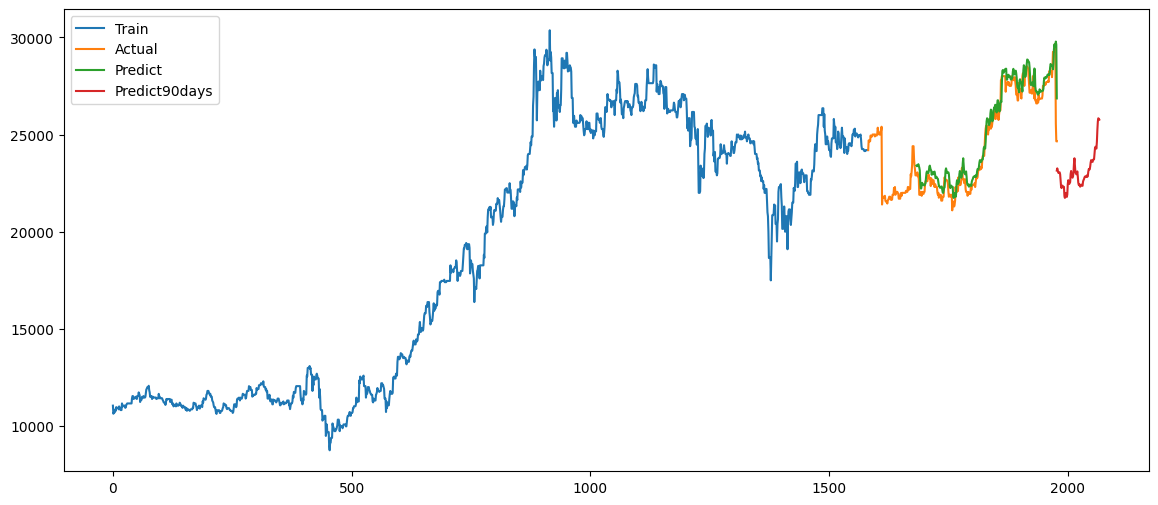

In [176]:
# 14.Vẽ hình 90 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_90_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90_days, scaler.inverse_transform(lst_output_90_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict90days'])
plt.show()

# SBS

In [177]:
# 2. Đọc file csv và gắng index với giá Close
df3= pd.read_csv('DataSBS.csv')
df_SBS=df3.reset_index()['Price']

In [178]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_SBS=scaler.fit_transform(np.array(df_SBS).reshape(-1,1))

In [179]:
df_SBS

array([[0.03960396],
       [0.03465347],
       [0.03465347],
       ...,
       [0.29207921],
       [0.29207921],
       [0.29207921]])

In [180]:
# 4. Chia train test
train_size = int(len(df_SBS) * 0.8)
test_size = len(df_SBS) - train_size
train_data, test_data = df_SBS[0:train_size, :], df_SBS[train_size:len(df_SBS), :1]


In [181]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [182]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [183]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [184]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [185]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 12s 199ms/step - loss: 0.0314
Epoch 2/100
24/24 [==============================] - 4s 168ms/step - loss: 0.0036
Epoch 3/100
24/24 [==============================] - 5s 196ms/step - loss: 0.0024
Epoch 4/100
24/24 [==============================] - 5s 209ms/step - loss: 0.0022
Epoch 5/100
24/24 [==============================] - 4s 169ms/step - loss: 0.0021
Epoch 6/100
24/24 [==============================] - 4s 186ms/step - loss: 0.0019
Epoch 7/100
24/24 [==============================] - 5s 215ms/step - loss: 0.0018
Epoch 8/100
24/24 [==============================] - 4s 168ms/step - loss: 0.0017
Epoch 9/100
24/24 [==============================] - 4s 175ms/step - loss: 0.0016
Epoch 10/100
24/24 [==============================] - 5s 219ms/step - loss: 0.0018
Epoch 11/100
24/24 [==============================] - 4s 167ms/step - loss: 0.0015
Epoch 12/100
24/24 [==============================] - 4s 169ms/step - loss: 0.0015
Epoch 13/100

In [186]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 38ms/step


In [187]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

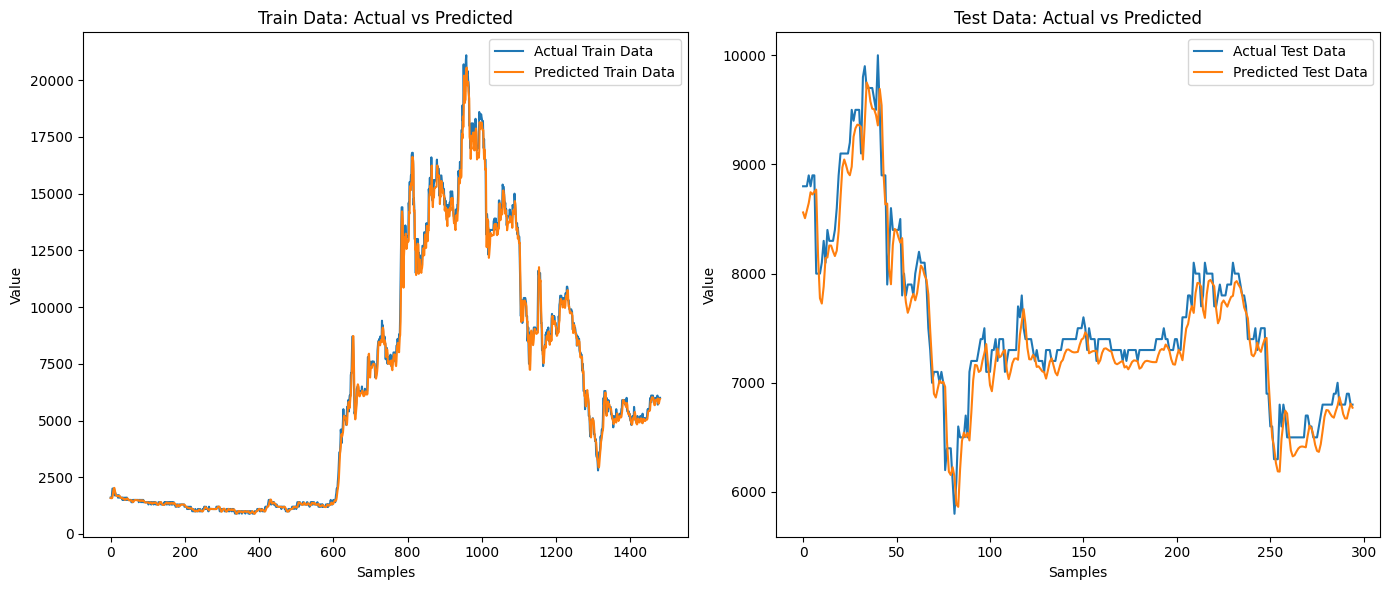

In [188]:
# Vẽ giá trị dự đoán và giá trị thực tế cho tập kiểm tra
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual Train Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual Test Data')
plt.plot(y_pred, label='Predicted Test Data')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [189]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))
print('Testing RMSE:', test_rmse)

mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f'Testing MAPE: {mape}')

mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Testing MAE: {mae}')

Testing RMSE: 220.22012022590266
Testing MAPE: 0.021912040676457818
Testing MAE: 166.42334646451286


In [190]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30_days=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30_days.extend(yhat.tolist())
        i=i+1

0 day input [0.32673267 0.34158416 0.33663366 0.33168317 0.33168317 0.33168317
 0.33168317 0.34158416 0.34653465 0.36633663 0.36633663 0.37128713
 0.37128713 0.37128713 0.36633663 0.36138614 0.35148515 0.35148515
 0.36138614 0.36138614 0.36138614 0.36633663 0.36138614 0.36138614
 0.35643564 0.36138614 0.36138614 0.36138614 0.36633663 0.35643564
 0.36138614 0.36138614 0.37128713 0.37128713 0.37128713 0.4009901
 0.4009901  0.3960396  0.38118812 0.39108911 0.39108911 0.39108911
 0.3960396  0.39108911 0.3960396  0.3960396  0.35148515 0.35148515
 0.35148515 0.35643564 0.36633663 0.35643564 0.37128713 0.36633663
 0.36633663 0.36633663 0.37128713 0.38118812 0.3960396  0.40594059
 0.40594059 0.40594059 0.40594059 0.40594059 0.41089109 0.42574257
 0.42079208 0.42574257 0.42574257 0.42574257 0.40594059 0.44059406
 0.44554455 0.43564356 0.43564356 0.43564356 0.43564356 0.43069307
 0.42574257 0.45049505 0.42574257 0.3960396  0.3960396  0.3960396
 0.34653465 0.36138614 0.38118812 0.37128713 0.37128

In [191]:
#14. Dự đoán 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60_days=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60_days.extend(yhat.tolist())
        i=i+1

0 day input [0.32673267 0.34158416 0.33663366 0.33168317 0.33168317 0.33168317
 0.33168317 0.34158416 0.34653465 0.36633663 0.36633663 0.37128713
 0.37128713 0.37128713 0.36633663 0.36138614 0.35148515 0.35148515
 0.36138614 0.36138614 0.36138614 0.36633663 0.36138614 0.36138614
 0.35643564 0.36138614 0.36138614 0.36138614 0.36633663 0.35643564
 0.36138614 0.36138614 0.37128713 0.37128713 0.37128713 0.4009901
 0.4009901  0.3960396  0.38118812 0.39108911 0.39108911 0.39108911
 0.3960396  0.39108911 0.3960396  0.3960396  0.35148515 0.35148515
 0.35148515 0.35643564 0.36633663 0.35643564 0.37128713 0.36633663
 0.36633663 0.36633663 0.37128713 0.38118812 0.3960396  0.40594059
 0.40594059 0.40594059 0.40594059 0.40594059 0.41089109 0.42574257
 0.42079208 0.42574257 0.42574257 0.42574257 0.40594059 0.44059406
 0.44554455 0.43564356 0.43564356 0.43564356 0.43564356 0.43069307
 0.42574257 0.45049505 0.42574257 0.3960396  0.3960396  0.3960396
 0.34653465 0.36138614 0.38118812 0.37128713 0.37128

In [192]:
#14. Dự đoán 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90_days=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input_trimmed = x_input[:100]
        x_input = x_input_trimmed.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90_days.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90_days.extend(yhat.tolist())
        i=i+1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 0.34158416 0.35148515 0.35643564 0.36138614 0.35643564 0.35643564
 0.35643564 0.34653465 0.32673267 0.31683168 0.3019802  0.30693069
 0.30693069 0.30693069 0.3019802  0.30693069 0.3019802  0.26237624
 0.27227723 0.27227723 0.27227723 0.25742574 0.24257426 0.25742574
 0.28217822 0.27722772 0.27722772 0.27722772 0.28712871 0.27722772
 0.30693069 0.31188119 0.31188119 0.31188119 0.31188119 0.31683168
 0.32178218 0.32178218 0.32673267 0.30693069 0.30693069 0.30693069
 0.31683168 0.31683168 0.32178218 0.31188119 0.32178218 0.32178218
 0.32178218 0.30693069 0.31188119 0.31683168 0.31683168 0.31683168
 0.31683168 0.31683168 0.33663366 0.33168317 0.34158416 0.32673267
 0.32178218 0.32178218 0.32178218 0.32178218 0.31683168 0.31188119
 0.31683168 0.31188119 0.31188119 0.31188119 0.30693069 0.31683168
 0.31683168 0.31683168 0.31188119 0.31188119 0.31188119 0.31683168
 0.31683168 0.31683168 0.32178218 0.32178218 0.32178218 0.32178218
 0.32

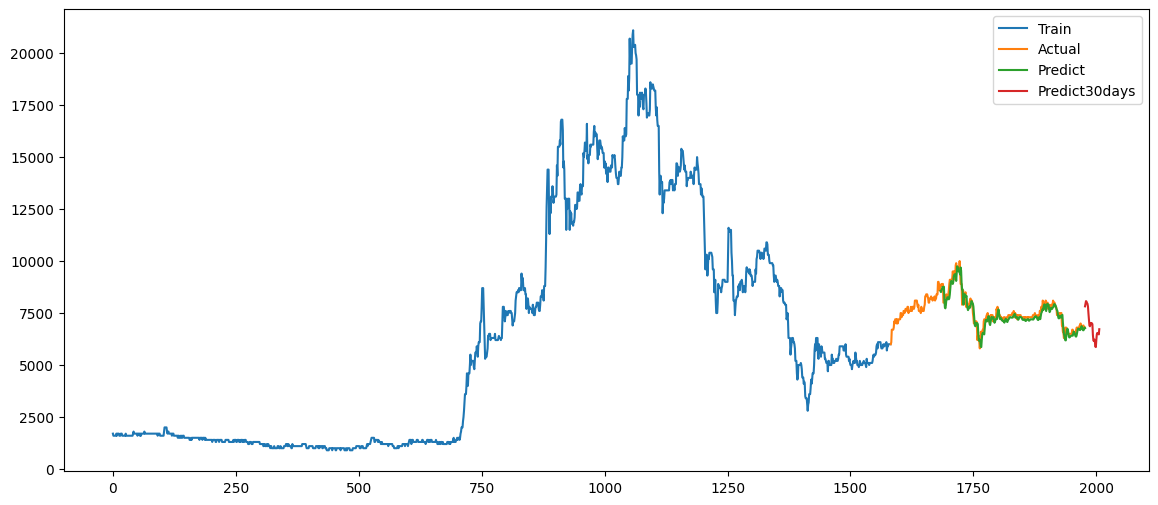

In [193]:
# 14.Vẽ hình 30 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_30_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30_days, scaler.inverse_transform(lst_output_30_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()


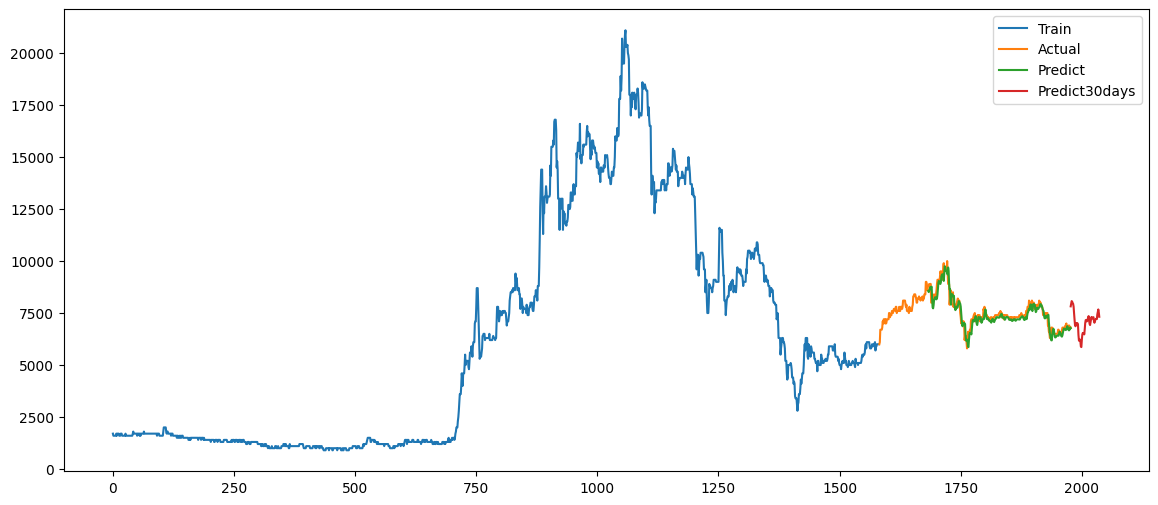

In [194]:
# 14.Vẽ hình 60 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_60_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60_days, scaler.inverse_transform(lst_output_60_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict30days'])
plt.show()

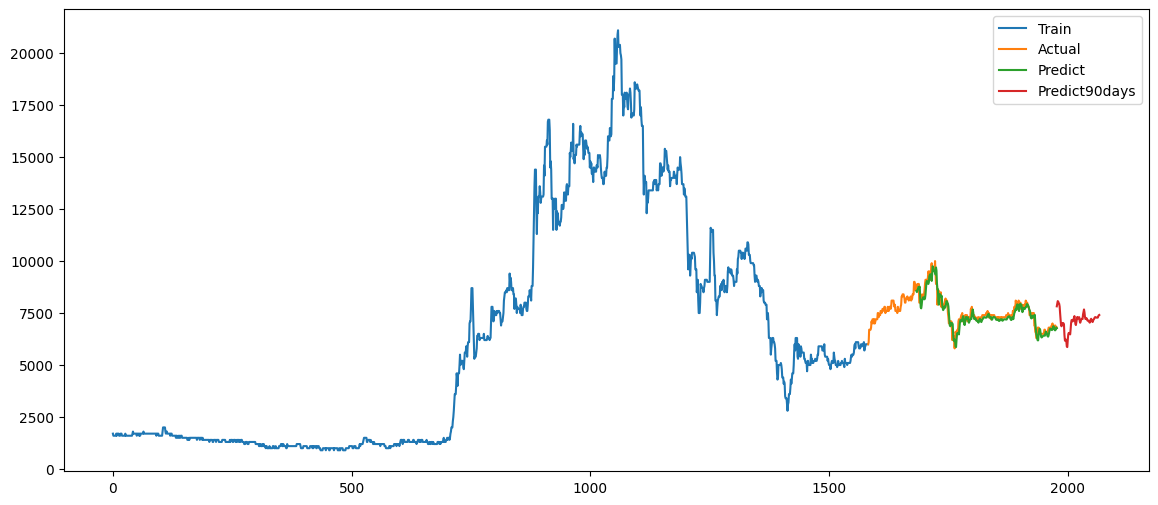

In [195]:
# 14.Vẽ hình 90 days
plt.figure(figsize=(14, 6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

predict_data_index_90_days = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90_days, scaler.inverse_transform(lst_output_90_days))

plt.legend(['Train', 'Actual', 'Predict', 'Predict90days'])
plt.show()